# Using a RIS model for multiple person segmentation

In this notebook we are going to use a previously trained model for multiple person segmentation in order to segment new images.

To start, please download the model, which is divided into 3 parts:

Part 1: https://drive.google.com/file/d/0B0DpzTZy_7pZek9TUW9mZXJNSVU/view?usp=sharing

Part 2: https://drive.google.com/file/d/0B0DpzTZy_7pZdVI3MC1hT05FalU/view?usp=sharing

Part 3: https://drive.google.com/file/d/0B0DpzTZy_7pZUmF1OGdyc2E0ZEE/view?usp=sharing

Put those model in some directory, and set the variable model_dir to be that directory. Also set the variable image_path to point to the directory where testing images reside. Finally create a text file with the names of the images you are interested in (e.g. if you want to use all images in model_dir, then do 

ls models_dir/*.jpg > list.txt


In [ ]:
model_dir = 'models_dir/'
image_path = '/mnt/DATADISK2/pose_proj/datasets/coco/images/test2015/'

-- We have a list of the images we want to test in the file image_path .. '../list.txt':
list_file = io.open(image_path .. '../list.txt', "r")

In [1]:
require 'nn'
require 'cunn'
require 'image'                                                           
require 'nnx'
require 'nngraph'
require 'Upsample'
require 'util.misc'
model_utils = require 'util.model_utils'

gpumode = 1  -- Running it on gpu
pascal_labels = {'Background', 'Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Dining-table', 'Dog', 'Horse', 'Motorbike', 'Person', 'Potted-Plant', 'Sheep', 'Sofa', 'Train', 'TV/Monitor' }

local seed = 1234567890
torch.manualSeed(seed)

function getParameter(nngraph_model, name)
    local params
    nngraph_model:apply( function(m) if m.name==name then params = m end end)
    return params
end


The following cell contains a function that loads and preprocesses the images:

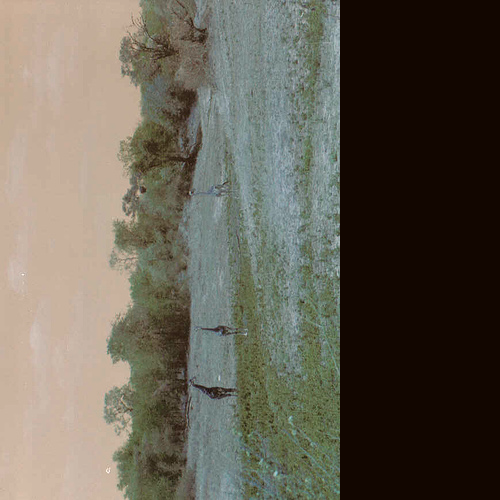

In [2]:
side_size = 500
nPixels = side_size*side_size
focus_class = {[15] = 1} -- We focus on person segmentation (class number 15)

function createInstance ()

    io.input(list_file)
    image_name = io.read()
    io.input(class_file)
    local class_set = io.read()
    if class_set==nil then
        print('New epoc.')
        -- closes the open file
        io.close(list_file)
        io.close(class_file)
        -- Opens a file in read
        list_file = io.open(image_path .. '../' .. train_or_val .. '_GT_list.txt', "r")

        io.input(list_file)
        image_name = io.read()
    end

    local input = image.load(image_path .. image_name)*255
    
    if (#input)[1]==1 then
        return nil, nil
    end

    local height = (#input)[2]
    local width = (#input)[3]

    if height>side_size and height>width then
        width = torch.floor(side_size/height*width)
        height = side_size
    end
    if width>side_size and width>=height then
        height = torch.floor(side_size/width*height)
        width = side_size
    end
    
    input = torch.reshape(image.scale(input, width, height):float(), 3, height, width)

    local actual_input = torch.Tensor(3, side_size, side_size):fill(0)
    actual_input[{ {1,3}, {1,height}, {1,width} }] = input
    
    
    local mean_pix = torch.Tensor({-103.939, -116.779, -123.68})
    local mean_pix_tensor = torch.repeatTensor(mean_pix, side_size,side_size,1)
    mean_pix_tensor = mean_pix_tensor:permute(3,1,2)

    local actual_input_aux = torch.Tensor(#actual_input)
    actual_input_aux[{{1},{},{}}] = actual_input[{{3},{},{}}]
    actual_input_aux[{{2},{},{}}] = actual_input[{{2},{},{}}]
    actual_input_aux[{{3},{},{}}] = actual_input[{{1},{},{}}]
    
    actual_input_aux:add(mean_pix_tensor)

    actual_input_aux = actual_input_aux:permute(1,3,2)
    
    if gpumode==1 then
        actual_input_aux = actual_input_aux:cuda()
    end
    return actual_input_aux, nil, nil
end

function create_instance_with_class()
    while true do
        input, tensorGt, gt_labels = createInstance()
        if input then
            return input, tensorGt, gt_labels
        end
    end
end

input, tensorGt, gt_labels = create_instance_with_class()
itorch.image(input:permute(1,3,2))

Now we load the models...

In [3]:
rnn_layers = 2  -- Number of layers of the ConvLSTM
nChannels = 100 -- Number of channels in the state of the ConvLSTM

model8_1 = torch.load(model_dir .. '/coco_fcn8_1.model')
model8_2 = torch.load(model_dir .. '/coco_fcn8_2.model')
protos = torch.load(model_dir .. '/coco_convlstm.model')

rnn_size = nChannels
xSize = 64
ySize = 64

... and initialize the recurrent stage:

In [4]:

-- make a bunch of clones after flattening, as that reallocates memory

seq_length = 7 -- This is the total number of iterations we run the model for each image.
               -- You can change it at your convenience.
clones = {}
for name,proto in pairs(protos) do
    print('cloning ' .. name)
    clones[name] = model_utils.clone_many_times(proto, seq_length, not proto.parameters)
end

fork_input = nn.Identity()()
local fork_outputs = {}
for i=1,seq_length do
    table.insert(fork_outputs, nn.Identity()(fork_input))
end
fork = nn.gModule({fork_input}, fork_outputs)
if gpumode==1 then
    fork = fork:cuda()
end

-- the initial state of the cell/hidden states
init_state = {}
for L=1,rnn_layers do
    local h_init = torch.zeros(rnn_size,xSize, ySize)
    if gpumode==1 then h_init = h_init:cuda() end
    table.insert(init_state, h_init:clone())
    table.insert(init_state, h_init:clone())
end

cloning post_lstm	


cloning shall_we_stop	


cloning rnn	


Everything is now in place to perform inference on images. Before going directly on instance segmentation, we are first going to visualize the feature maps produced by the FCN, which are the input to the ConvLSTM:

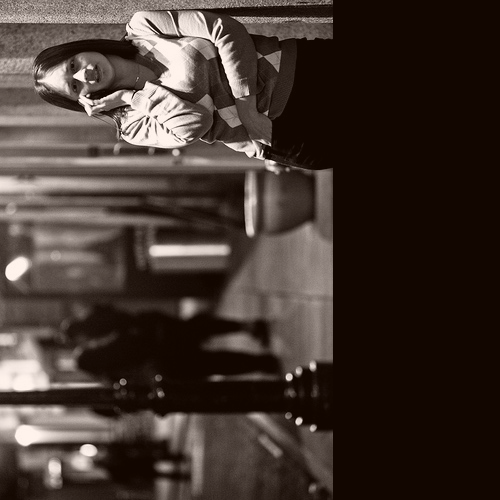

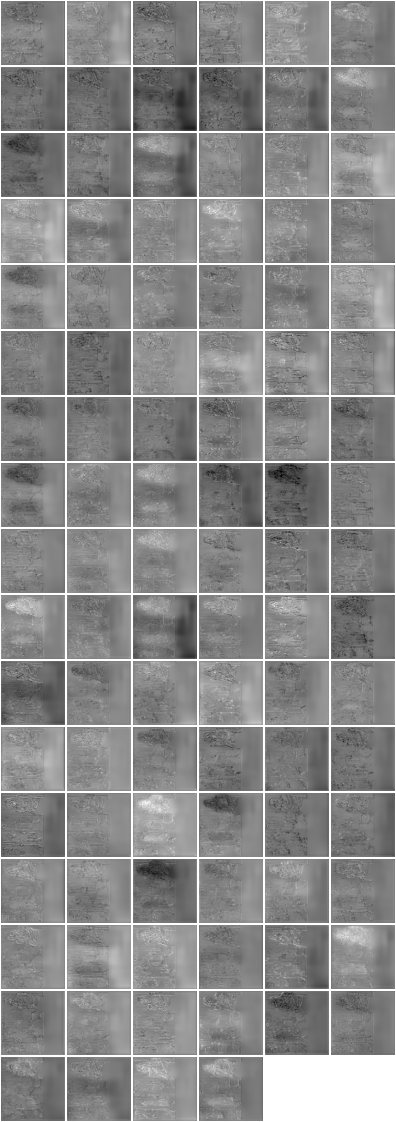

In [6]:
-- Testing...
inputSize = 3
input, tensorGt = create_instance_with_class()

itorch.image(input:sub(1,3):permute(1,3,2))
model8_1:evaluate()
model8_2:evaluate()
x = model8_2:forward(model8_1:forward(input))
itorch.image(x:permute(1,3,2))

Now let us try to segment an image:

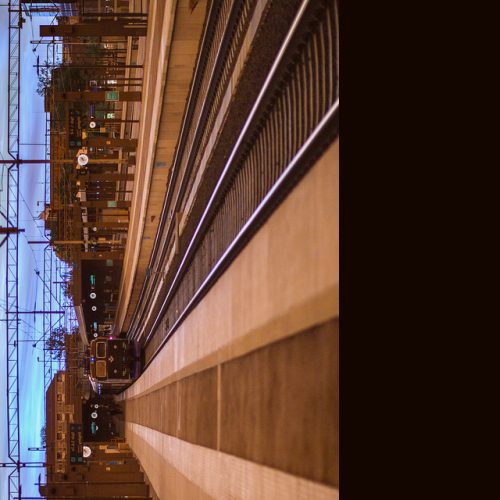

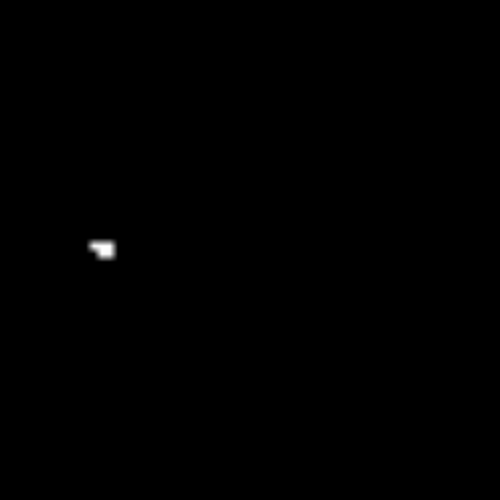

 0.1425
[torch.CudaTensor of size 1]



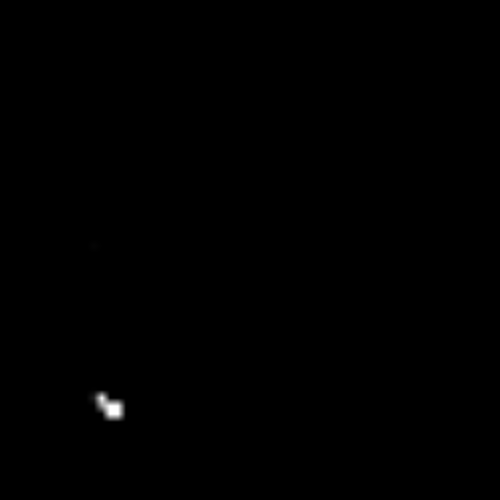

 0.2901
[torch.CudaTensor of size 1]



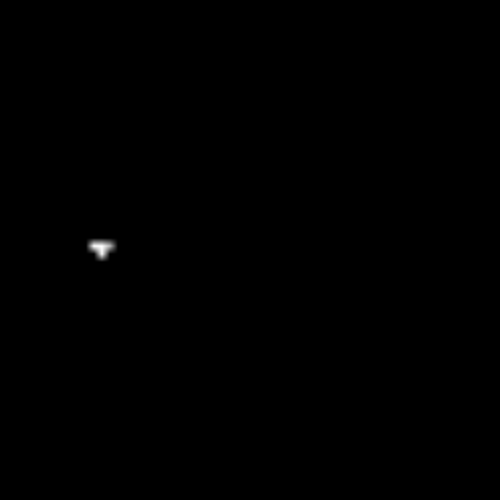

 0.2997
[torch.CudaTensor of size 1]



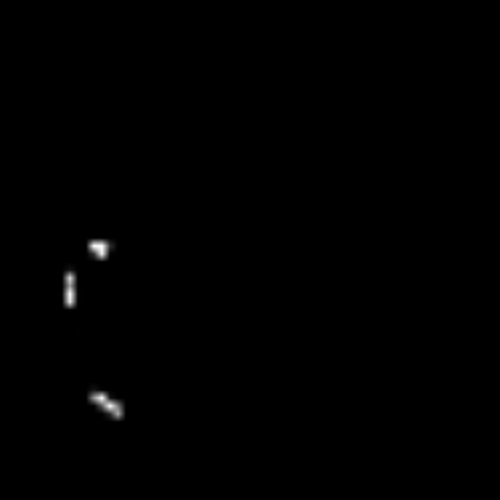

 0.2997
[torch.CudaTensor of size 1]



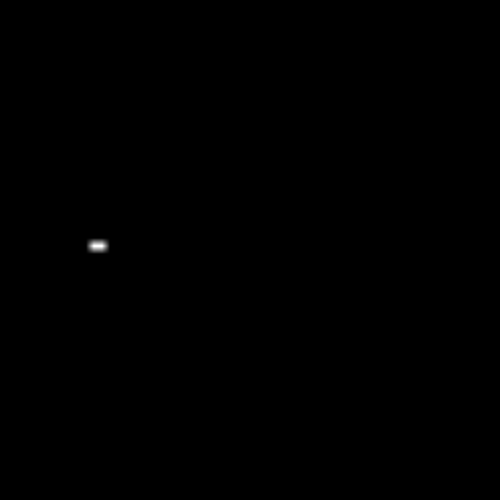

 0.2975
[torch.CudaTensor of size 1]



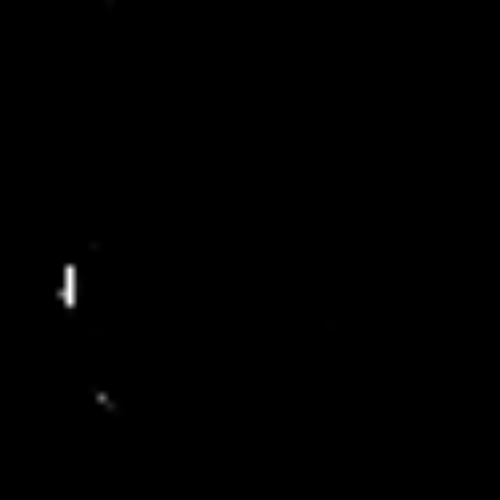

 0.2528
[torch.CudaTensor of size 1]



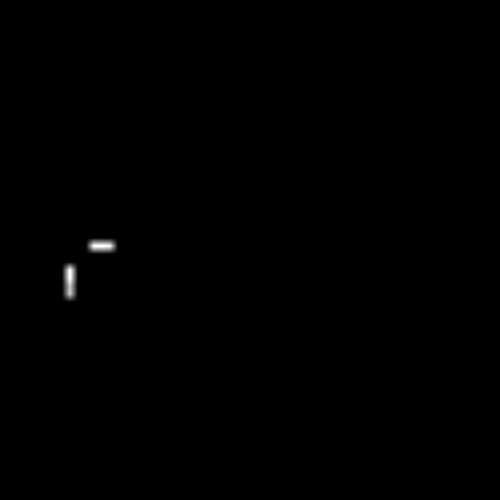

 0.2944
[torch.CudaTensor of size 1]


In [13]:
Plot = require 'itorch.Plot'
-- Testing...
inputSize = 3
input, tensorGt = create_instance_with_class()

itorch.image(input:sub(1,3):permute(1,3,2))
model8_1:evaluate()
model8_2:evaluate()
x = model8_2:forward(model8_1:forward(input))

-- the initial state of the cell/hidden states
local init_state_global = {} 
for L=1,rnn_layers do
    local h_init = torch.zeros(rnn_size,xSize, ySize)
    if gpumode==1 then h_init = h_init:cuda() end
    table.insert(init_state_global, h_init:clone())
    table.insert(init_state_global, h_init:clone())
end

local rnn_state = {[0] = init_state_global}
local predictions_small = {}
local predictions = {}
prediction = {}
local loss = 0
local gt_indices = {}

for t=1,seq_length do
    local lst = protos.rnn:forward{x, unpack(rnn_state[t-1])}
    rnn_state[t] = {}
    for i=1,#init_state do table.insert(rnn_state[t], lst[i]) end -- extract the state, without output
    predictions_small[t] = lst[#lst] -- last element is the prediction
    
    local state = lst[#lst-1]:clone():pow(2):sum(1):squeeze()    
    predictions[t] = protos.shall_we_stop:forward(protos.post_lstm:forward(predictions_small[t]))
    result = predictions[t][1]
    itorch.image(result:permute(1,3,2))
    print(predictions[t][2])
end

Run the previous cell as many times as you want with different images. It should produce a sequence of seq_length pairs of (mask, confidence score). The model is ''considering'' that there are no more instances when the score is below 0.5, and so, the corresponding mask and the ones following are irrelevant.

In [ ]:
-- Closing stuff:
io.close(list_file)